In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset

In [2]:
# read in reflectivity classification for time 36 hr
file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/strat.nc'
with Dataset(file, 'r') as nc:
    c_type_og = nc.variables['strat'][36,:,:,:] # time, level, lat, lon
c_type_og = np.squeeze(c_type_og)

In [3]:
# Read in mixing ratios
q_list = ['QVAPOR','QICE', 'QSNOW', 'QGRAUP', 'QCLOUD', 'QRAIN']
q_var = np.empty((6,20,740,1200)) # mixing ratios type x level x lat x lon
for var in range(len(q_list)):
    file = '/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/haiyan/memb_01/ctl/post/d02/' + q_list[var] + '.nc'
    with Dataset(file, 'r') as nc:
        q_var[var,:,:,:] = nc.variables[q_list[var]][36,:,:,:] # hour 36 only; time x level x lat x lon

In [4]:
# constants
g = 9.8 # [m/s^2]
del_p = 50*10**2 # [Pa]

In [5]:
# vertically integrate mixing ratios
q_int = (1/(g))*np.sum(q_var, axis=1)*del_p # density is absorbed into the unit conversion; units: [mm]

In [6]:
# Calculate IWP, CWP, and Cloud Ratio
IWP = q_int[1,:,:]+q_int[2,:,:]+q_int[3,:,:] # [mm]; ice + snow + graupel
CWP = q_int[4,:,:]+q_int[5,:,:] # [mm]; cloud + rain
TWP = IWP + CWP # [mm]; total water path
CR = IWP/CWP # cloud ratio
inf_ind = (CR==np.inf) # find where values are inf
ninf_ind = (CR==-np.inf) # find where values are -inf
CR[inf_ind] = np.nan # mask inf values
CR[ninf_ind] = np.nan # mask -inf values

/tmp/ipykernel_4918/3180468627.py:5: RuntimeWarning: divide by zero encountered in true_divide
  CR = IWP/CWP # cloud ratio
/tmp/ipykernel_4918/3180468627.py:5: RuntimeWarning: invalid value encountered in true_divide
  CR = IWP/CWP # cloud ratio


In [7]:
# Mask IWP for reflectivity classification type
precip_list = ['conv', 'strat', 'mixed']
CR_og = np.empty((3,740,1200))
TWP_mask_og = np.empty((3,740,1200))
for t in range(np.size(precip_list)):
    not_cloud = (c_type_og!=(t+1))
    CR_og[t] = CR.copy()
    CR_og[t,not_cloud==True] = np.nan
    TWP_mask_og[t] = TWP.copy()
    TWP_mask_og[t,not_cloud==True] = np.nan

I,K,L = np.shape(CR_og)
CR_og = np.reshape(CR_og,(I,K*L))

I,J,K = np.shape(TWP_mask_og)
TWP_mask_og = np.reshape(TWP_mask_og,(I,J*K))

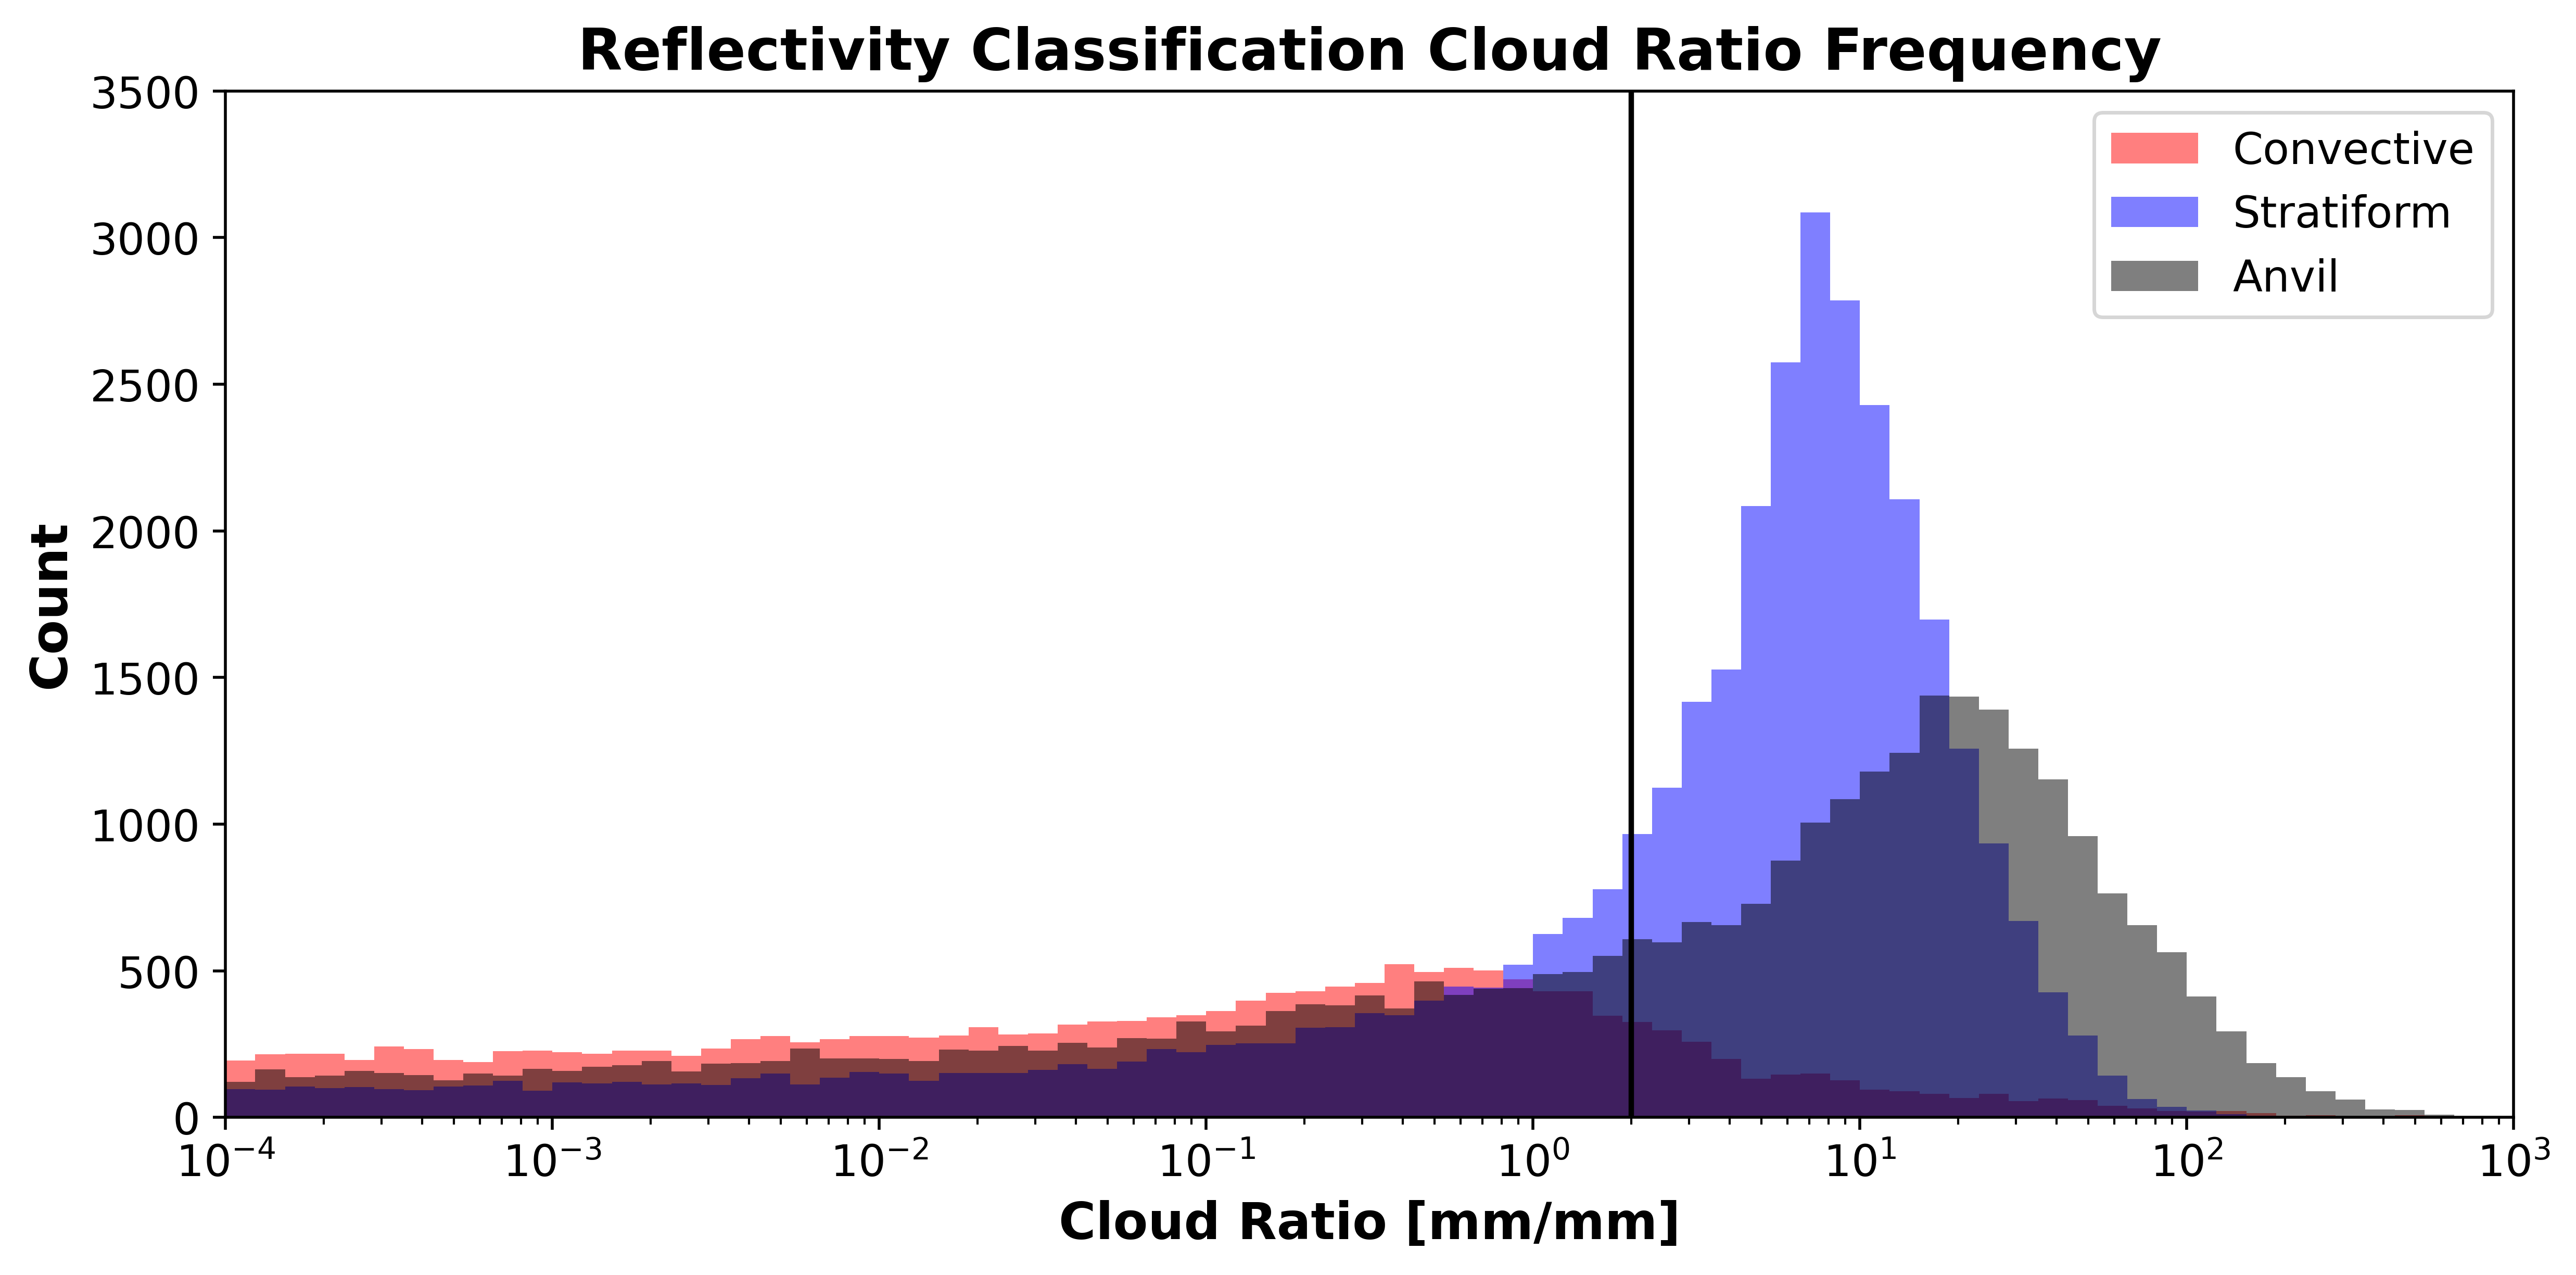

In [8]:
# Reflectivity Classification CR Frequency
cbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)
sbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)
mbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)

fig = plt.figure(figsize=(10,5), facecolor='white', dpi=500)
plt.hist(CR_og[0], bins=sbins, color='red', alpha=0.5, label= 'Convective')
plt.hist(CR_og[1], bins=sbins, color='blue',alpha=0.5, label= 'Stratiform')
plt.hist(CR_og[2], bins=mbins, color='black', alpha=0.5, label= 'Anvil')
plt.legend(loc='upper right', fontsize=12)
plt.axvline(x=2, color='black')
plt.yticks(ticks=np.arange(0,3501,500), fontsize=12)
plt.ylim(0,3500)
plt.ylabel('Count', size=14, weight='bold')
plt.xlabel('Cloud Ratio [mm/mm]', size=14, weight='bold')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.xlim((1e-4,1e3))
plt.title('Reflectivity Classification Cloud Ratio Frequency', size=16, weight='bold')
plt.tight_layout()

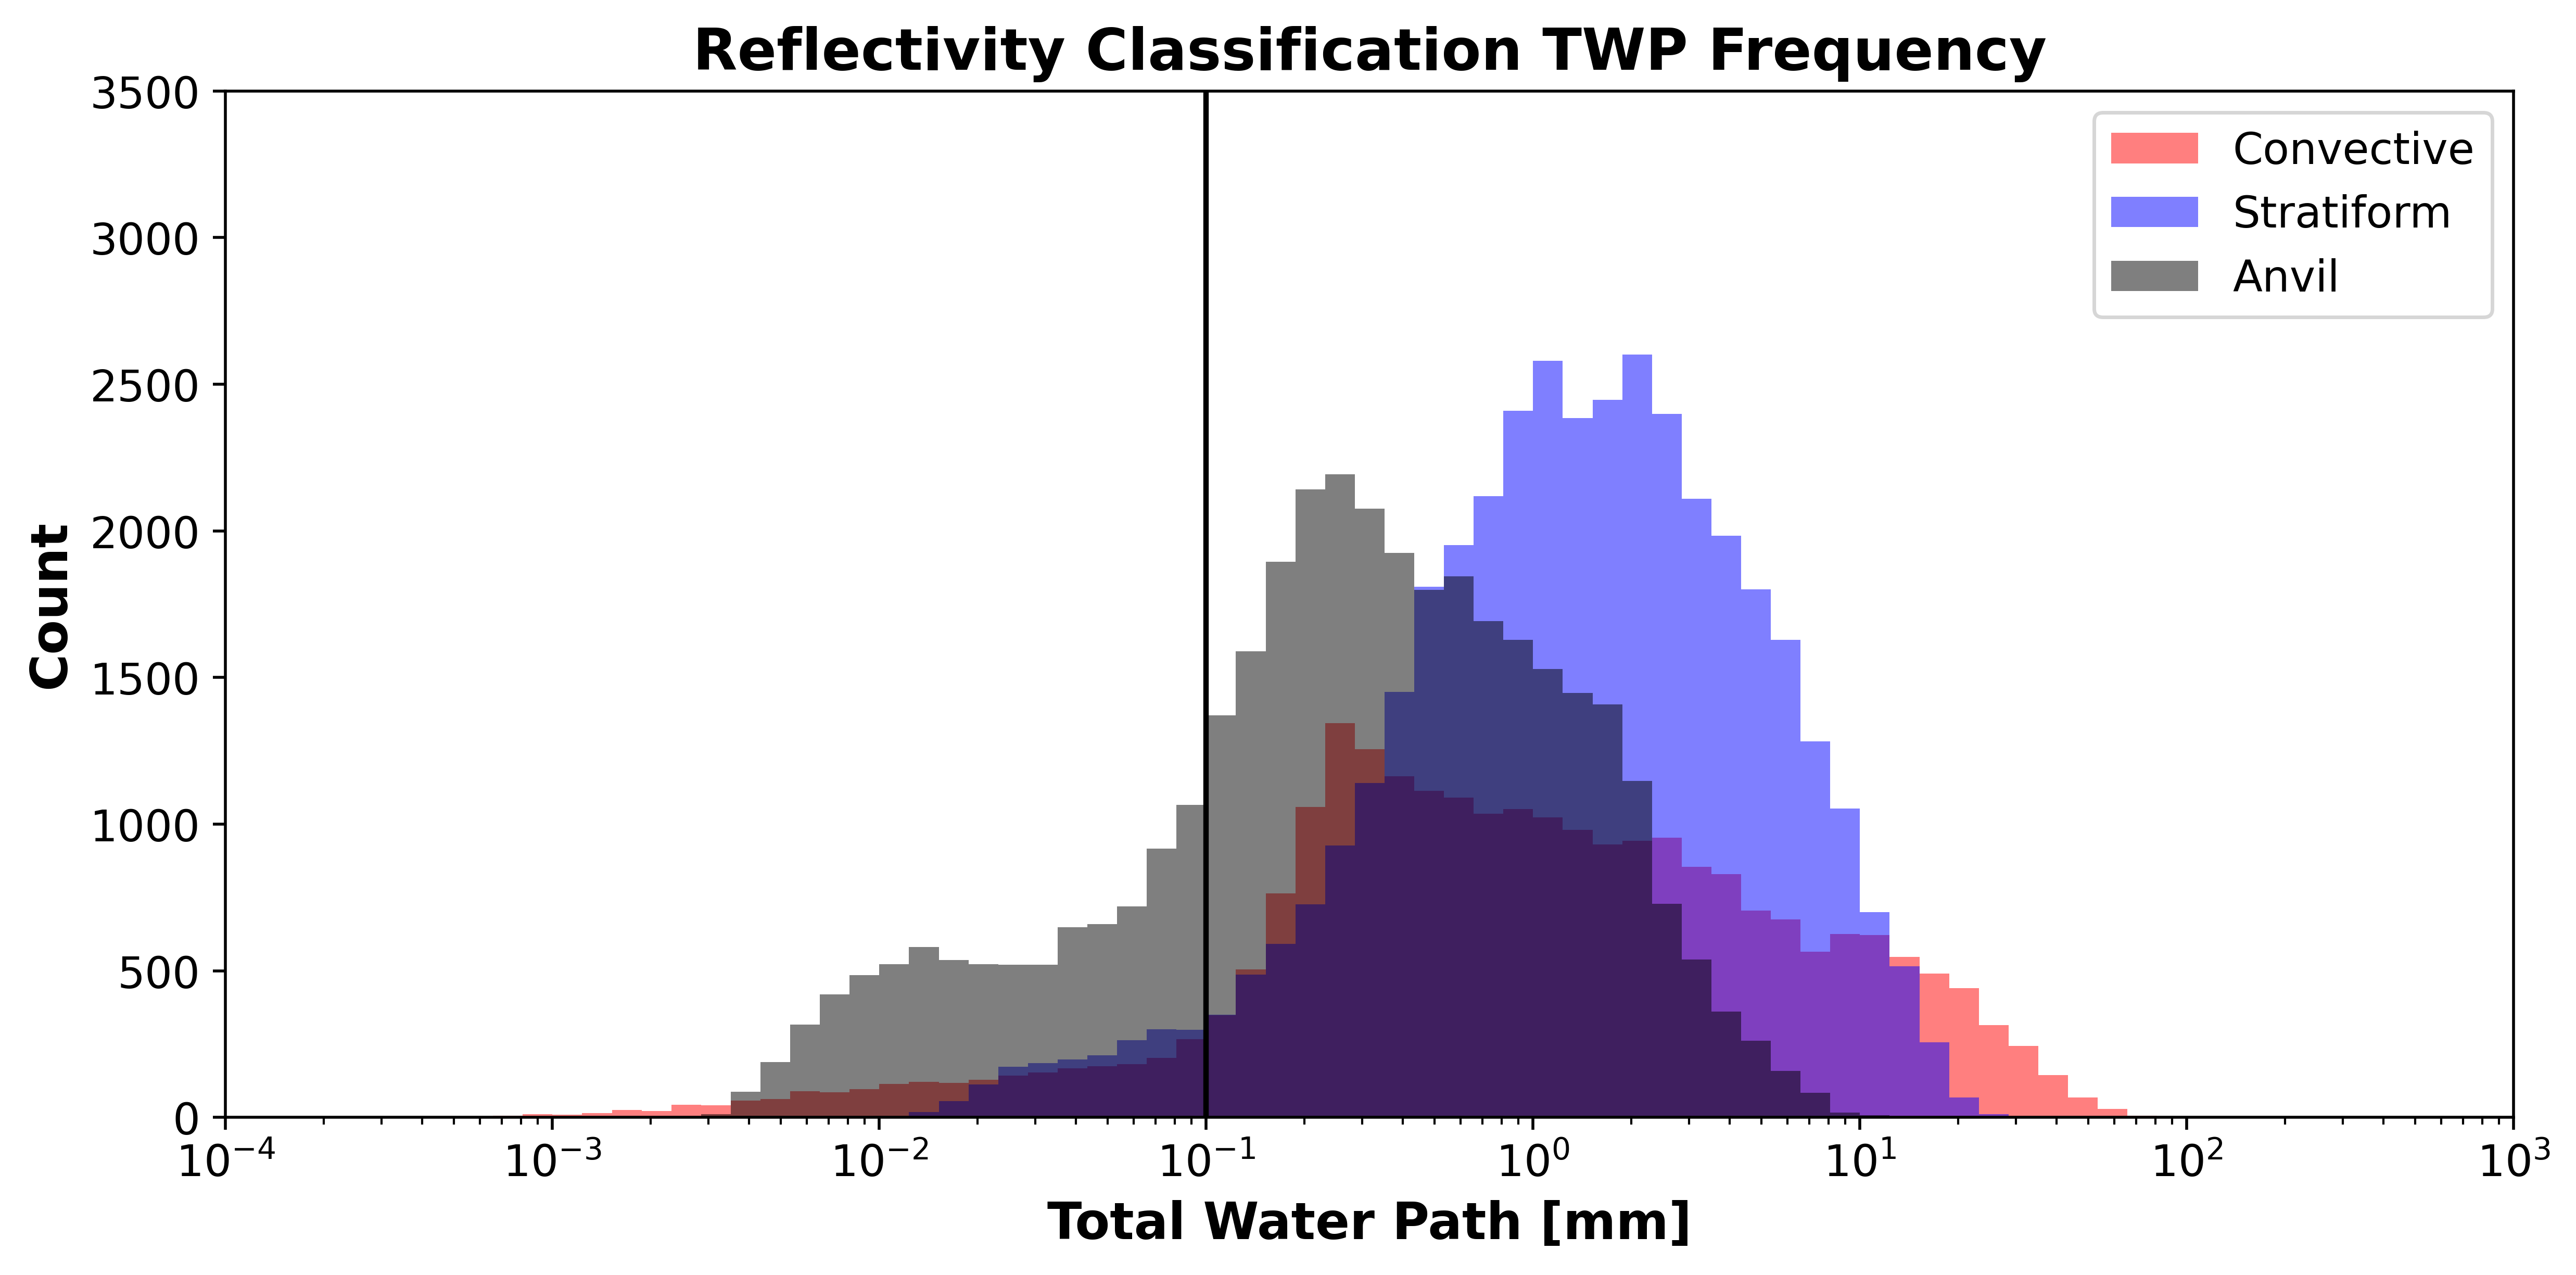

In [9]:
# Refectivity Classification TWP Frequency
cbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)
sbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)
mbins=np.logspace(np.log10(0.000001),np.log10(1000), 100)

fig = plt.figure(figsize=(10,5), facecolor='white', dpi=500)
plt.hist(TWP_mask_og[0], bins=sbins, color='red', alpha=0.5, label= 'Convective')
plt.hist(TWP_mask_og[1], bins=sbins, color='blue',alpha=0.5, label= 'Stratiform')
plt.hist(TWP_mask_og[2], bins=mbins, color='black', alpha=0.5, label= 'Anvil')
plt.legend(loc='upper right', fontsize=12)
plt.axvline(x=0.1, color='black')
plt.yticks(ticks=np.arange(0,3501,500), fontsize=12)
plt.ylim(0,3500)
plt.ylabel('Count', size=14, weight='bold')
plt.xlabel('Total Water Path [mm]', size=14, weight='bold')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.xlim((1e-4,1e3))
plt.title('Reflectivity Classification TWP Frequency', size=16, weight='bold')
plt.tight_layout()